- [1. Importing Datsets and Functions](#1)
- [2. Assembling Datasets](#2)
- [3. Modeling](#3)
    - [3.1 Random Forest](#3_1)
- [4. Hyperparameters Tuning](#4)
    - [4.1 Random Forest Tuning](#4_1)

## 1. Import Datasets and Functions <a id='1'></a>

In [42]:
from tqdm import tqdm  # Import tqdm
import pandas as pd
import numpy as np
import sklearn
import torch.nn as nn
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, brier_score_loss, r2_score, mean_squared_error, mean_absolute_error, silhouette_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import seaborn as sns


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [2]:
def add_target(team):
    team['target'] = team['won'].shift(-1)
    return team

def rest_days(team):
    team['date_time'] = pd.to_datetime(team['date'])
    team['rest'] = (team['date_time'] - team['date_time'].shift(1)).dt.days
    team['rest'] = team['rest'].fillna(0)
    team['rest'] = team['rest'].astype(int)
    del team['date_time']
    return team

def winrate(team):
    total = team['Wins'] + team['Losses']
    total_opp = team['Wins_opp'] + team['Losses_opp']
    team['winrate'] = team['Wins'] / total
    team['winrate_opp'] = team['Wins_opp'] / total_opp
    return team

def differential(team):
    team['differential'] = team['Total'] - team['Total_opp']
    return team

def find_team_exp_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=5, adjust=False).mean()
    return rolling

def find_team_exp_average_9(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=9, adjust=False).mean()
    return rolling

def find_team_exp_average_12(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.ewm(span=12, adjust=False).mean()
    return rolling

def find_team_average_15(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(15).mean()
    return rolling

def find_team_average_10(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(10).mean()
    return rolling

def find_team_average_5(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(5).mean()
    return rolling

def find_team_average_3(team):
    numeric_columns = team.select_dtypes(include=np.number)
    rolling = numeric_columns.rolling(3).mean()
    return rolling

def rolling(data):
    df_rolling_3 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_3 = df_rolling_3.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_3)
    df_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_5 = df_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_5)
    df_rolling_10 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_10 = df_rolling_10.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_10)
    df_rolling_15 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_rolling_15 = df_rolling_15.groupby(['Teams', 'season'], group_keys = False).apply(find_team_average_15)
    df_exp_rolling_5 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_5 = df_exp_rolling_5.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_5)
    df_exp_rolling_9 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_9 = df_exp_rolling_9.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_9)
    df_exp_rolling_12 = data[list(valid_columns) + ['Teams','won', "season"]]
    df_exp_rolling_12 = df_exp_rolling_12.groupby(['Teams', 'season'], group_keys = False).apply(find_team_exp_average_12)
    exp_rolling_columns_5 = [f"{col}_exp_5" for col in df_exp_rolling_5.columns]
    exp_rolling_columns_9 = [f"{col}_exp_9" for col in df_exp_rolling_9.columns]
    exp_rolling_columns_12 = [f"{col}_exp_12" for col in df_exp_rolling_12.columns]
    rolling_columns_15 = [f"{col}_15" for col in df_rolling_15.columns]
    rolling_columns_10 = [f"{col}_10" for col in df_rolling_10.columns]
    rolling_columns_5 = [f"{col}_5" for col in df_rolling_5.columns]
    rolling_columns_3 = [f"{col}_3" for col in df_rolling_3.columns]
    df_exp_rolling_12.columns = exp_rolling_columns_12
    df_exp_rolling_9.columns = exp_rolling_columns_9
    df_exp_rolling_5.columns = exp_rolling_columns_5
    df_rolling_15.columns = rolling_columns_15
    df_rolling_10.columns = rolling_columns_10
    df_rolling_5.columns = rolling_columns_5
    df_rolling_3.columns = rolling_columns_3
    df = pd.concat([data, df_rolling_3, df_rolling_5, df_rolling_10, df_rolling_15, df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12], axis=1)
    # df_exp_rolling_5,df_exp_rolling_9, df_exp_rolling_12
    return df

def ratio(feature):
    feature_opp = 'OPP_' + str(feature)
    free = nba[feature] / nba[feature_opp]
    return free

def ratios(nba):
    regard = []
    disregard = [col for col in nba.columns if "OPP_" in col]
    for col in disregard:
        col = col[4:100]
        if col in nba.columns:
            regard.append(col)
    nba_ratio = nba[regard].apply(ratio)
    nba_ratios_columns = [f"{col}_ratio" for col in nba_ratio.columns]
    nba_ratio.columns
    return regard

def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("Teams", group_keys=False).apply(lambda x: shift_col(x, col_name))

def date_change(datetime_str):
    # Parse the datetime string into a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%m/%d/%Y')

    # Format the datetime object into a new string structure
    new_datetime_str = datetime_obj.strftime('%Y-%m-%d')

    return new_datetime_str

def haircut(df, date):
    df[date] = df[date].str[:10]
    return df

def convert_date_format(df):
    # Create a boolean mask to identify values in the "m/d/y" format
    mask = df['Date'].str.contains(r'\d{1,2}/\d{1,2}/\d{2}')
    
    # Apply the conversion only to values that match the mask
    df.loc[mask, 'Date'] = nba.loc[mask, 'Date'].apply(date_change)
    return df

def spread(df):
    # construct spread between home and away rankings
    ranks = [i for i in df.columns if 'RANK' in i]
    ranks_home = [i for i in ranks if '_x' in i]
    ranks_away = [i for i in ranks if '_y' in i]
    spread_columns_names = [col[:-1] for col in ranks_home]
    
    spread_columns = []
    for base_name in spread_columns_names:
        spread_column = df[f'{base_name}x'] - df[f'{base_name}y']
        spread_column.name = f'{base_name}spread'
        spread_columns.append(spread_column)
        
    spread_df = pd.concat(spread_columns, axis=1)
    return spread_df

def last_season(df):
    # construct winrate from last season
    df['last_season_winrate'] = df.groupby('Teams', 'season')['winrate'].last()

## 2. Assembling Dataset <a id='2'></a>

In [4]:
folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/raw_data/NBA_2018_2024.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/raw_data/NBA_2018_2024.csv"

df = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/nba_api/data/teams_stats/processed_cumulative_season_stats_2019_2024.csv"
nba = pd.read_csv(folder_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [5]:
# nba dataframe does not include the 2018 season
df = df[~df['season'].isin([2018])]
df = df.reset_index(drop=True)
df = haircut(df, 'date')

# rename nba columns to match df
nba = haircut(nba, 'Date')
nba = convert_date_format(nba)
nba.rename(columns={'Date': 'date'}, inplace=True)

#rename odds columns to match df
odds.rename(columns={'Timestamp': 'date_next'}, inplace=True)

# construct winrate for team
df = winrate(df)
# construct differential points
df = differential(df)
# construct target
df = df.groupby("Teams", group_keys=False).apply(add_target)
# construct resting
df = df.groupby(["Teams",'season'], group_keys=False).apply(rest_days)
# games yet to play are 2
df.loc[pd.isnull(df['target']), 'target'] = 2
# convert win/loss to 1/0
df['target'] = df['target'].astype(int)

# remove metadata and target for df
removed = ['target', 'date', 'Teams_opp', 'Teams',
           'season','won', 'Wins', 'Losses', 
           'Wins_opp', 'Losses_opp']
valid_columns = df.columns[~df.columns.isin(removed)]

# scale the data for df
scaler = MinMaxScaler()
df[valid_columns] = scaler.fit_transform(df[valid_columns])

# construct rolling features to df
df = rolling(df).copy()
df = df.dropna()

# remove metadata for nba ranking 
removed = ['date', 'Teams']
valid_columns = nba.columns[~nba.columns.isin(removed)]

# scale the ranking data
scaler = MinMaxScaler()
nba[valid_columns] = scaler.fit_transform(nba[valid_columns])

# remove metadata for odds data
# removed = list(odds.columns[odds.dtypes == 'object'])
# valid_columns = odds.columns[~nba.columns.isin(removed)]

# scale the odds data
# scaler = MinMaxScaler()
# odds[valid_columns] = scaler.fit_transform(odds[valid_columns])

# construct current game metadata for df
df['home_next'] = add_col(df, 'home')
df['team_next_opp'] = add_col(df, 'Teams_opp')
df['date_next'] = add_col(df, 'date')
df = df.copy()

# merge stats from nba dataframe
full = pd.merge(df, nba, on=['Teams', 'date'], how='left')
full = full.dropna()

# merge stats from opposing teams
complete = full.merge(full,
               left_on=['Teams', 'date_next'],
               right_on = ['team_next_opp', 'date_next'])

# concat the spreads
spread_df = spread(complete)
complete = pd.concat([complete, spread_df], axis=1)

# concat the odds
complete = pd.merge(complete, odds, on=['Teams_x', 'date_next', 'Teams_y'], how='left')
complete = complete.dropna()

In [6]:
complete_cleaning = complete.copy()
# Dropping duplicated columns
complete_cleaning = complete_cleaning.T.drop_duplicates(keep='first').T
for column in complete_cleaning.columns:
    complete_cleaning[column] = pd.to_numeric(complete_cleaning[column], errors='ignore')
# remove metadata and useless data
disregard = list(complete_cleaning.columns[complete_cleaning.dtypes == 'object']) 
# disregard = disregard + ["target_x","target_y"]
# Temporary change for tuning

disregard = disregard + ["target_y", "target_x"]
regard = complete_cleaning.columns[~complete_cleaning.columns.isin(disregard)]

In [7]:
# want to exclude January 2024 - March 2024 data from dataframe to use for out of sample testing
complete_cleaning = complete_cleaning[~complete_cleaning['date_next'].str.contains('2024-03')|complete_cleaning['date_next'].str.contains('2024-02')|complete_cleaning['date_next'].str.contains('2024-01')]
complete_cleaning = complete_cleaning.reset_index(drop=True)

## 3. Modeling <a id='3'></a>

### 3.1 Random Forest Classifier <a id='3_1'></a>

In [10]:
X = complete_cleaning[regard]
y = complete_cleaning['target_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [13]:
feature_importances = rf.feature_importances_
feature_names = X.columns

# Map feature names to their importance scores
importances = zip(feature_names, feature_importances)
sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)

for name, importance in sorted_importances:
    print(f"{name}: {importance}")

Draftkings_odds_x: 0.012745144676889586
BetMGM_odds_x: 0.010910634760440545
Draftkings_odds_y: 0.010182228129871235
BetMGM_odds_y: 0.008796156890100666
Fanduel_odds_x: 0.008551049588986781
Fanduel_odds_y: 0.008171167232163584
PIE_RANK_advanced_spread: 0.004091313849298554
W_RANK_base_spread: 0.0026937601237898186
PLUS_MINUS_RANK_base_spread: 0.002570669819258414
NET_RATING_RANK_advanced_spread: 0.002381016790650693
W_PCT_RANK_base_spread: 0.0022943856886366893
L_RANK_base_spread: 0.0020887843021764833
PLUS_MINUS_base_x: 0.0018933633947698042
PLUS_MINUS_opponent_x: 0.0018857713651825308
NET_RATING_advanced_x: 0.0017651026451327473
TS_PCT_RANK_advanced_spread: 0.0017080971098271096
winrate_exp_12_y: 0.001687041080010804
FG3_PCT_RANK_base_spread: 0.0016565695383964616
winrate_10_x: 0.0014834419120487666
W_PCT_base_y: 0.001463914383158
winrate_exp_5_y: 0.0014495338152080302
PLUS_MINUS_opponent_y: 0.0014221097335842673
winrate_exp_5_x: 0.0013714688324835017
PLUS_MINUS_base_y: 0.001296113911

In [30]:
len([i for i in feature_importances if i > 0.00045])/(feature_importances.shape[0])

0.1643316925407043

In [47]:
len([i for i in feature_importances if i > 0.0005])

251

In [58]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
X = complete_cleaning[regard]
# Keep the top 251 indices
top_251_indices = indices[:400]
# If X is a pandas DataFrame
if isinstance(X, pd.DataFrame):
    top_251_feature_names = X.columns[top_251_indices]
    X_top_251 = X[top_251_feature_names]
else:
    X_top_251 = X[:, top_251_indices]

feature_names = X.columns if isinstance(X, pd.DataFrame) else np.array(['Feature1', 'Feature2', 'Feature3', ...]) 
selected_features = []
for i in top_251_indices:
    print(f"{feature_names[i]}: {importances[i]}")
    selected_features += [feature_names[i]]


Draftkings_odds_x: 0.012745144676889586
BetMGM_odds_x: 0.010910634760440545
Draftkings_odds_y: 0.010182228129871235
BetMGM_odds_y: 0.008796156890100666
Fanduel_odds_x: 0.008551049588986781
Fanduel_odds_y: 0.008171167232163584
PIE_RANK_advanced_spread: 0.004091313849298554
W_RANK_base_spread: 0.0026937601237898186
PLUS_MINUS_RANK_base_spread: 0.002570669819258414
NET_RATING_RANK_advanced_spread: 0.002381016790650693
W_PCT_RANK_base_spread: 0.0022943856886366893
L_RANK_base_spread: 0.0020887843021764833
PLUS_MINUS_base_x: 0.0018933633947698042
PLUS_MINUS_opponent_x: 0.0018857713651825308
NET_RATING_advanced_x: 0.0017651026451327473
TS_PCT_RANK_advanced_spread: 0.0017080971098271096
winrate_exp_12_y: 0.001687041080010804
FG3_PCT_RANK_base_spread: 0.0016565695383964616
winrate_10_x: 0.0014834419120487666
W_PCT_base_y: 0.001463914383158
winrate_exp_5_y: 0.0014495338152080302
PLUS_MINUS_opponent_y: 0.0014221097335842673
winrate_exp_5_x: 0.0013714688324835017
PLUS_MINUS_base_y: 0.001296113911

-----------------------------------Fold 1-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.7001327110022763
The brier score is:0.22136341427735517
The accuracy is, 0.6512580456407255
The calibrated model scoring: 
The roc_auc score is:0.6948126295952384
The brier score is:0.22700392639550707


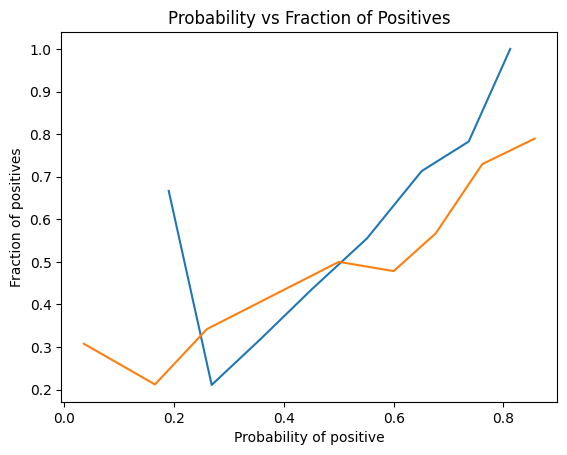

-----------------------------------Fold 2-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.6950516867351074
The brier score is:0.22256541837331772
The accuracy is, 0.652428320655354
The calibrated model scoring: 
The roc_auc score is:0.6939957653581095
The brier score is:0.22232746515632598


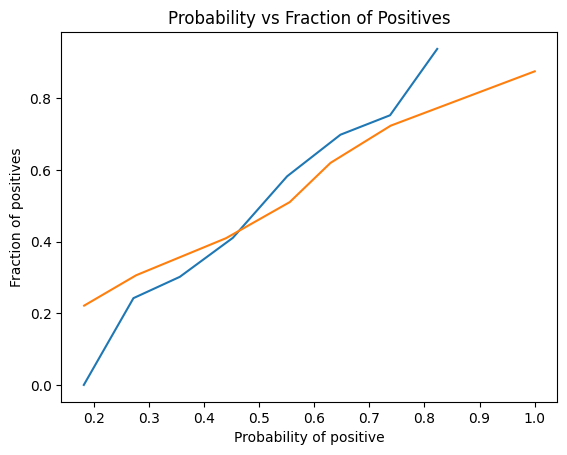

-----------------------------------Fold 3-----------------------------------
The uncalibrated model scoring: 
The roc_auc score is:0.7295451744114385
The brier score is:0.21406410181392624
The accuracy is, 0.6799297834991223
The calibrated model scoring: 
The roc_auc score is:0.7257570154895435
The brier score is:0.21426609775932273


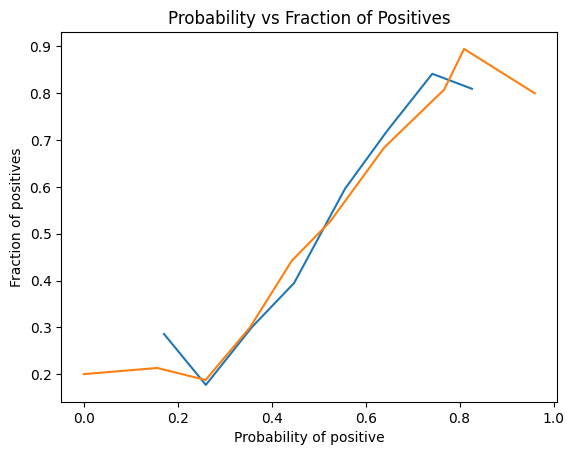

In [59]:
X = complete_cleaning[selected_features]
y = complete_cleaning['target_x']

best_brier_score = float('inf')
best_model = None
fold = 0

clf = RandomForestClassifier(n_estimators=200, random_state=42)
test_size = len(y) // 4

tscv = TimeSeriesSplit(n_splits=3, test_size=test_size)
fold = 0
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # include a validation set for calibration
    split_index = int(len(X_train) * 0.8)  # 80% training, 20% validation
    X_train_split, X_val = X_train[:split_index], X_train[split_index:]
    y_train_split, y_val = y_train.iloc[:split_index], y_train.iloc[split_index:]
    
    fold += 1 
    
    clf.fit(X_train_split, y_train_split)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    print(f'-----------------------------------Fold {fold}-----------------------------------')
    print('The uncalibrated model scoring: ')
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc}')
    brier = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier}')
    predictions = clf.predict(X_test)    
    accuracy = accuracy_score(y_test, predictions)
    print("The accuracy is,", accuracy)
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    
    # calibrate the model using the validation sets
    calibrated_clf = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_val, y_val)
    y_pred = calibrated_clf.predict_proba(X_test)[:, 1]
    
    print('The calibrated model scoring: ')
    roc_auc_calibrated = roc_auc_score(y_test, y_pred)
    print(f'The roc_auc score is:{roc_auc_calibrated}')
    brier_calibrated = brier_score_loss(y_test, y_pred)
    print(f'The brier score is:{brier_calibrated}')
    
    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=10)
    sns.lineplot(x=pred_prob, y=frac_of_positives)
    plt.title("Probability vs Fraction of Positives")
    xlabel = plt.xlabel("Probability of positive")
    ylavel = plt.ylabel("Fraction of positives")
    plt.show()
    
    if(brier_calibrated < best_brier_score):
        best_brier_score = brier_calibrated
        best_model = calibrated_clf

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2', None],  # The number of features to consider when looking for the best split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'class_weight': [None, 'balanced', 'balanced_subsample']  # Weights associated with classes
}

tscv = TimeSeriesSplit(n_splits=3)
results_df = pd.DataFrame()
X = complete_cleaning[regard]
y = complete_cleaning['target_x']

for n_features in [100, 250, 500]:
    # Iterate over all combinations generated by ParameterGrid
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_251_indices = indices[:n_features]
    # If X is a pandas DataFrame
    if isinstance(X, pd.DataFrame):
        top_251_feature_names = X.columns[top_251_indices]
        X_top_251 = X[top_251_feature_names]
    else:
        X_top_251 = X[:, top_251_indices]
    
    feature_names = X.columns if isinstance(X, pd.DataFrame) else np.array(['Feature1', 'Feature2', 'Feature3', ...]) 
    selected_features = []
    for i in top_251_indices:
        selected_features += [feature_names[i]]
    print("Currently Working on Tuning with Top", n_features)

    for params in tqdm(list(ParameterGrid(param_grid)), desc="Hyperparameter Tuning Progress"):
        # List to store the Brier scores for each split
        results_list = []
        split_scores = []
    
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
            # Initialize, train and calibrate the model for the current split
            clf = RandomForestClassifier(**params)
            clf.fit(X_train, y_train)
            calibrated_clf = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
            calibrated_clf.fit(X_train, y_train)
    
            # Predict probabilities and calculate Brier score
            y_pred_probs = calibrated_clf.predict_proba(X_test)[:, 1]
            split_score = brier_score_loss(y_test, y_pred_probs)
            split_scores.append(split_score)
    
        # Store the parameters and their corresponding average and individual Brier scores
        results_list.append({
            **params,
            'Average_Brier_score': np.mean(split_scores),
            'First_Brier_scores': split_scores[0],
            'Second_Brier_scores': split_scores[1],
            'Third_Brier_scores': split_scores[2],
            'n_features': n_features
        })

# Sorting the results based on the average Brier score
results_df.sort_values(by='Average_Brier_score', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

Currently Working on Tuning with Top 100


Hyperparameter Tuning Progress:   2%| | 90/5184 [31:43:08<8387:18:29, 5927.43s/i